jupyter notebook which goes through data cleaning 

In [408]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F
import os
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [409]:
df = spark.read.parquet('../data/landing/property_data.parquet')
initial_instances = df.count()

In [410]:
import re
pdf = df.toPandas()

# Delete Rows that do not contain the price in cost_text
valid_costs = [x if re.search(r"([\d\.]+)", x) else 0 for x in pdf['cost_text']]
pdf['cost_text'] = valid_costs
pdf = pdf[pdf['cost_text']!=0]

# Remove commas
pdf['cost'] = pdf['cost_text'].replace(',','', regex=True)

# Manual deletions 
pdf = pdf.drop(8235) # invalid cost

In [411]:
sdf = spark.createDataFrame(pdf)

In [412]:
raw_sdf = sdf.withColumn(
    # Properties priced per week
    'Week',
    F.when(F.lower(F.col('cost_text')).contains('pw') \
           | F.lower(F.col('cost_text')).contains('p/w') \
           | F.lower(F.col('cost_text')).contains('wk') \
           | F.lower(F.col('cost_text')).contains('/w') \
           | F.lower(F.col('cost_text')).contains('week'), True).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'month',
    F.when(F.lower(F.col('cost_text')).contains('month') \
        | F.lower(F.col('cost_text')).contains('per month') \
        | F.lower(F.col('cost_text')).contains('pcm'), True ).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'contains_pa',
    F.when(F.lower(F.col('cost_text')).contains('p.a') \
        | F.lower(F.col('cost_text')).contains('pa') \
        | F.lower(F.col('cost_text')).contains('per annum') \
        | F.lower(F.col('cost_text')).contains('per year') \
        | F.lower(F.col('cost_text')).contains('per_annum') \
        | F.lower(F.col('cost_text')).contains('p/a'), True ).otherwise(False)
).withColumn(
    # remove $ and ,
    'cost',
    F.regexp_replace(F.col("cost"), r"[$]", "") # casting to float makes it include the decimal point
).withColumn(
    # removes decimal places
    'cost',
    F.regexp_replace(F.col("cost"), r"\.\d+", "")
)

In [413]:
pdf = raw_sdf.toPandas()

In [414]:
pdf['cost'] = [(re.findall(r'\d\d+', x)) for x in pdf['cost']]

In [415]:
pdf['cost'] = [x[0] if (len(x)>=1) else 0 for x in pdf['cost'] ] # extract lowest estimate  of price when a range is given

for i in range(len(pdf)):
    if ((pdf['month'][i] == True)&(pdf['Week'][i]==False)):
        cost = re.findall(r'\d+', pdf['cost'][i])[0]
        # Divide monthly cost by 4
        pdf['cost'][i] = int(cost)/4
    if ((pdf['month'][i] == False)&(pdf['Week'][i]==False)&((pdf['contains_pa'][i])==True)):
        cost = re.findall(r'\d+', pdf['cost'][i])[0]
        # Divide annual cost by 52
        pdf['cost'][i] = int(cost)/52

In [416]:
pdf[(pdf['month'] == False)&(pdf['Week']==False)&((pdf['contains_pa'])==True)] # Cost is working

# Delete invalid costs
pdf = pdf.drop(4951)
pdf = pdf.drop(10581)

pdf[(pdf['month'] == False)&(pdf['Week']==False)&((pdf['contains_pa'])==True)] # Cost is working


,url,postcode,suburb,name,cost_text,beds,baths,parking,property_type,cost,Week,month,contains_pa
3106,https://www.domain.com.au/8-chamberlain-road-r...,3523,redcastle,"8 Chamberlain Road, Redcastle VIC 3523","$28,000 Per Year !!",None,None,0,Vacant land,538.461538,False,False,True
4900,https://www.domain.com.au/22-enterprise-way-ya...,3730,yarrawonga,"22 Enterprise Way, Yarrawonga VIC 3730","$52,000 per annum plus GST",1,1,4,New House & Land,1000.0,False,False,True
6357,https://www.domain.com.au/667-glenhuntly-road-...,3162,caulfield,"667 Glenhuntly Road, Caulfield VIC 3162","$38,000 p.a. Incl. Outgoings + GST",None,None,0,House,730.769231,False,False,True
7664,https://www.domain.com.au/12-panama-street-wol...,3750,wollert,"12 Panama Street, Wollert VIC 3750","LEASED for $33,500 PA in ONE HOUR!",4,2,2,House,644.230769,False,False,True
9720,https://www.domain.com.au/30-south-concourse-b...,3193,beaumaris,"30 South Concourse, Beaumaris VIC 3193","$39,000 p.a + Outgoings",0,1,0,Studio,750.0,False,False,True


In [417]:
# Convert pdf back to spark
raw_sdf = spark.createDataFrame(pdf)

# Delete? # pdf = pdf.drop(4950)
# pdf = pdf.drop(10579)

In [418]:
raw_sdf = raw_sdf.withColumn(
    # see if property is furnished - note: this will contain partially furnished as well
    'furnished', 
    F.when(F.lower(F.col('cost_text')).contains('furnish') \
        | F.lower(F.col('cost_text')).contains('furniture'), True ).otherwise(False)
)

raw_sdf

url,postcode,suburb,name,cost_text,beds,baths,parking,property_type,cost,Week,month,contains_pa,furnished
https://www.domai...,3141,south-yarra,(Leased) 3 Yarra ...,$460,1,1,1,Apartment / Unit ...,460,false,false,false,false
https://www.domai...,3125,burwood,04/390 Burwood Hi...,"$310 per week, wi...",1,1,0,Apartment / Unit ...,310,true,false,false,false
https://www.domai...,3156,ferntree-gully,1 & 2/32 Folkston...,$800,4,3,1,House,800,false,false,false,false
https://www.domai...,3228,torquay,"1 Acacia Street, ...","$1,000 per week",4,2,2,House,1000,true,false,false,false
https://www.domai...,3200,frankston-north,1 Aleppo Crescent...,$450,3,1,1,House,450,false,false,false,false
https://www.domai...,3011,footscray,1 Bed 1 Bath/34 C...,$480 P/W,1,1,0,Apartment / Unit ...,480,true,false,false,false
https://www.domai...,3011,footscray,1 Bed 1 Bath/48 C...,$500 P/W,1,1,1,Apartment / Unit ...,500,true,false,false,false
https://www.domai...,3030,point-cook,1 Bensonhurst Par...,$570 per week,4,2,2,House,570,true,false,false,false
https://www.domai...,3047,broadmeadows,"1 Biltris Court, ...",$500,3,1,2,House,500,false,false,false,false
https://www.domai...,3149,mount-waverley,1 Birralee Street...,$625 per week,3,1,1,House,625,true,false,false,false


In [419]:
pdf[7521:7532] # 12 beds???

,url,postcode,suburb,name,cost_text,beds,baths,parking,property_type,cost,Week,month,contains_pa
7522,https://www.domain.com.au/11-34-chertsey-road-...,3630,shepparton,"11/34 Chertsey Road, Shepparton VIC 3630",$300,2,1,1,Apartment / Unit / Flat,300,False,False,False
7523,https://www.domain.com.au/11-37-hotham-street-...,3182,st-kilda,"11/37 Hotham Street, St Kilda VIC 3182",$385 pw,1,1,1,Apartment / Unit / Flat,385,True,False,False
7524,https://www.domain.com.au/11-42-alfred-street-...,3181,prahran,"11/42 Alfred Street, Prahran VIC 3181",$475 Per Week,2,1,0,Apartment / Unit / Flat,475,True,False,False
7525,https://www.domain.com.au/11-48-scott-street-e...,3040,essendon,"11/48 Scott Street, Essendon VIC 3040",$375,1,1,1,Apartment / Unit / Flat,375,False,False,False
7526,https://www.domain.com.au/11-5-carmichael-stre...,3012,west-footscray,"11/5 CARMICHAEL STREET, West Footscray VIC 3012",$320,1,1,1,Apartment / Unit / Flat,320,False,False,False
7527,https://www.domain.com.au/11-5-wattle-avenue-g...,3163,glen-huntly,"11/5 Wattle Avenue, Glen Huntly VIC 3163",$520 per week,2,1,1,Apartment / Unit / Flat,520,True,False,False
7528,https://www.domain.com.au/11-647-toorak-road-t...,3142,toorak,"11/647 Toorak Road, Toorak VIC 3142",$465 Per Week,1,1,1,Apartment / Unit / Flat,465,True,False,False
7529,https://www.domain.com.au/11-780-782-warrigal-...,3145,malvern-east,"11/780-782 Warrigal Road, Malvern East VIC 3145",$520 pw,2,1,1,Apartment / Unit / Flat,520,True,False,False
7530,https://www.domain.com.au/11-8-maury-road-chel...,3196,chelsea,"11/8 Maury Road, Chelsea VIC 3196",$540,2,1,2,Apartment / Unit / Flat,540,False,False,False
7531,https://www.domain.com.au/11-9-11-weller-stree...,3175,dandenong,"11/9-11 Weller Street, Dandenong VIC 3175",$ 540 PER WEEK,3,1,1,Apartment / Unit / Flat,540,True,False,False


Exploratory Data Analysis

In [420]:
from pyspark.sql.functions import col
# Aggregate by postcode

raw_sdf = raw_sdf.select(
    col('cost').cast('float'),
    col('postcode').cast('int'),
    col('suburb').cast('string'),
    col('beds').cast('int'),
    col('baths').cast('int')
  )

In [421]:
pdf = raw_sdf.toPandas()
suburbs = pdf.groupby(['postcode'])[['cost', 'beds','baths']].mean()
suburbs = suburbs.round()
suburbs[0:10]

,cost,beds,baths
postcode,,,
3000,646.0,2.0,1.0
3002,860.0,2.0,1.0
3003,782.0,2.0,1.0
3004,715.0,2.0,1.0
3006,789.0,2.0,1.0
3008,746.0,2.0,1.0
3011,1166.0,2.0,1.0
3012,563.0,2.0,2.0
3013,658.0,3.0,1.0


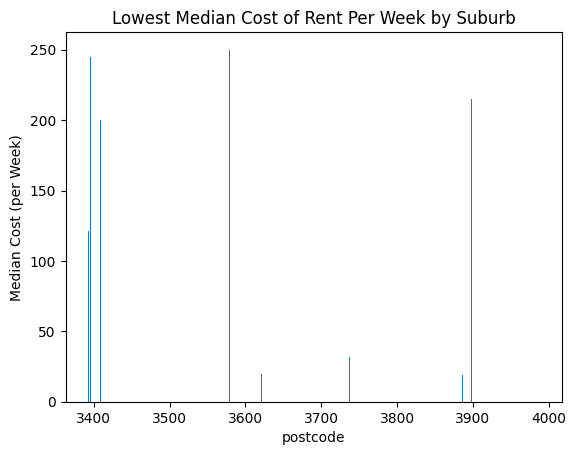

In [422]:
medians = pdf.groupby(["postcode"])["cost"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['cost'])

# Importing required libraries 
import matplotlib.pyplot as plt 

#fig = plt.figure(figsize = (7, 4))

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['cost'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median Cost (per Week)")
plt.title("Lowest Median Cost of Rent Per Week by Suburb")
plt.show()

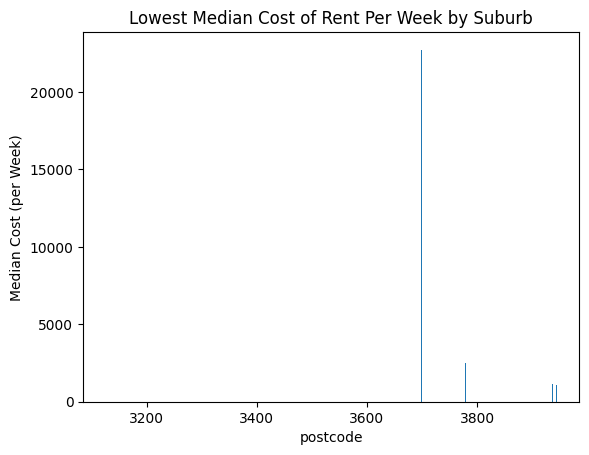

In [423]:
medians = pdf.groupby(["postcode"])["cost"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['cost'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

#fig = plt.figure(figsize = (7, 4))

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['cost'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median Cost (per Week)")
plt.title("Lowest Median Cost of Rent Per Week by Suburb")
plt.show()

In [424]:
maxValues = pdf['cost'].max(skipna=True)
maxValues

np.float32(95000.0)

In [425]:
suburbs_sdf = raw_sdf.groupby('postcode').mean('cost')
suburbs_sdf 
pdf_suburbs = suburbs_sdf.toPandas()
sorted_suburbs = suburbs_sdf.sort('avg(cost)', ascending = False)
top10_sdf = sorted_suburbs.limit(10)
top10_sdf

# Scatterplots - sample

postcode,avg(cost)
3699,23476.666666666668
3779,2500.0
3953,1949.607142857143
3428,1800.0
3787,1660.0
3944,1400.0
3331,1275.0
3186,1272.96875
3187,1179.78125
3720,1177.5


In [426]:
pdf_suburbs[pdf_suburbs['postcode']==3699] # check outliers


,postcode,avg(cost)
229,3699,23476.666667


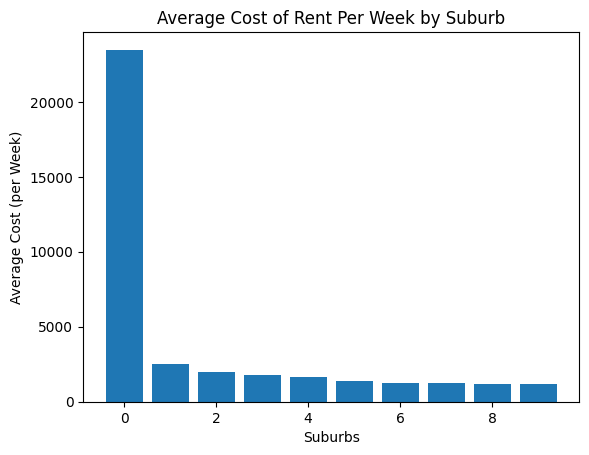

In [427]:
# Importing required libraries 
import matplotlib.pyplot as plt 

top10_pdf = top10_sdf.toPandas()
  
  
#fig = plt.figure(figsize = (7, 4))

# creating the bar plot
plt.bar(list(top10_pdf.index), top10_pdf['avg(cost)']) # fix x label, fix outliers, data check

plt.xlabel("Suburbs")
plt.ylabel("Average Cost (per Week)")
plt.title("Average Cost of Rent Per Week by Suburb")
plt.show()